In [27]:
#Import libraries

from sklearn import metrics
import pandas as pd
import numpy as np
from pyparsing import col
from requests import head
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from torch import rand
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error

In [2]:
#Read in data 

#User data
df = pd.read_csv('udata.txt', sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']

#Users
users = pd.read_csv('uuser.txt', sep='|', header=None)
users.columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']

#genre data
genre = pd.read_csv('ugenre.txt', sep='|', header=None)
genre.columns = ['genre', 'genre_id']

#occupation data
job = pd.read_csv('uoccupation.txt', sep='|', header=None)
job.columns = ['occupation']
job = job.reset_index().rename(columns={'index': 'job'})

#other items
items = pd.read_csv('uitem.txt', sep='|', header=None)
items.columns = ['movie_id', 'movie_title', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

In [18]:
#Combine/clean data

data = df.merge(users, how='left', on = 'user_id').merge(job, how = 'left', on='occupation').merge(items, how='left', left_on='item_id', right_on='movie_id')
data[data.Western.isna()]
data = data[data.Western.notna()].astype({'Western': 'int'})
data.gender.unique()
data['gender_id'] = np.where(data.gender == 'M', 0, 1)

#subset data to movies with over 100 reviews and reviewers with over 5 reviews
data = data[data.groupby("item_id")["item_id"].transform("size")>100]
data = data[data.groupby("user_id")["user_id"].transform("size")>5]



,user_id,item_id,rating,timestamp,age,gender,occupation,zip_code,job,movie_id,...,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,gender_id
0,196,242,3,881250949,49,M,writer,55105,20,242,...,0,0,0,0,0,0,0,0,0,0
1,186,302,3,891717742,39,F,executive,00000,6,302,...,1,0,0,1,0,0,1,0,0,1
4,166,346,1,886397596,47,M,educator,55113,3,346,...,0,0,0,0,0,0,0,0,0,0
5,298,474,4,884182806,44,M,executive,01581,6,474,...,0,0,0,0,0,1,0,1,0,0
6,115,265,2,881171488,31,M,engineer,17110,4,265,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,913,209,2,881367150,27,M,student,76201,18,209,...,0,0,1,0,0,0,0,0,0,0
99995,880,476,3,880175444,13,M,student,83702,18,476,...,0,0,0,0,0,0,0,0,0,0
99996,716,204,5,879795543,36,F,administrator,44265,0,204,...,0,0,0,0,0,1,0,0,0,1
99998,13,225,2,882399156,47,M,educator,29206,3,225,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Rating Distribution')

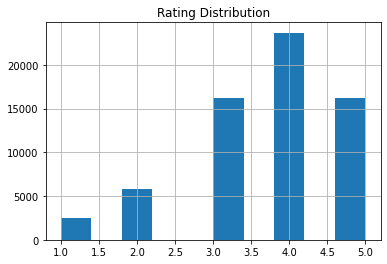

In [19]:
#Look at response variable distribution
data.hist(column = 'rating')
plt.title("Rating Distribution")

Text(0.5, 1.0, 'Age Distribution')

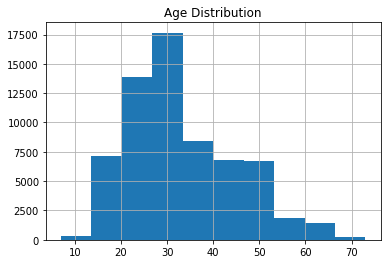

In [20]:
#Glance at other distributions

data.hist(column = 'age')
plt.title("Age Distribution")

In [21]:
#Convert to long format data for genre for correlation analysis

dataLong = pd.melt(data, id_vars = ['user_id', 'item_id', 'rating', 'timestamp', 'age', 'gender',
                        'occupation', 'zip_code', 'job', 'movie_id', 'movie_title','video_release_date', 'imdb_url',
                               'gender_id'],
        var_name = "genre",
       value_name = "values")
dataLong = dataLong.loc[dataLong['values'] == 1]
dataLong = dataLong.drop("values", 1)

correlation_matrix = dataLong.corr()
correlation_matrix

,user_id,item_id,rating,timestamp,age,job,movie_id,gender_id
user_id,1.000000,0.004791,-0.020384,0.015701,-0.076674,0.102957,0.004791,0.016460
item_id,0.004791,1.000000,-0.083368,0.039931,0.029183,-0.013662,1.000000,0.018215
rating,-0.020384,-0.083368,1.000000,-0.028731,0.014868,-0.029289,-0.083368,-0.002641
timestamp,0.015701,0.039931,-0.028731,1.000000,0.146612,0.045547,0.039931,0.026940
age,-0.076674,0.029183,0.014868,0.146612,1.000000,-0.358746,0.029183,-0.025151
job,0.102957,-0.013662,-0.029289,0.045547,-0.358746,1.000000,-0.013662,-0.022080
movie_id,0.004791,1.000000,-0.083368,0.039931,0.029183,-0.013662,1.000000,0.018215
gender_id,0.016460,0.018215,-0.002641,0.026940,-0.025151,-0.022080,0.018215,1.000000


In [22]:
# split into train/test for kNN

features = ['rating', 'age', 'gender_id', 'job', 'unknown', 'Action', 'Adventure', 'Animation','Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western']

data_x = data[features].drop(columns=['rating'])
data_y = data[['rating']]

train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.33, random_state=123)



In [23]:
test_x

,age,gender_id,job,unknown,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
58376,55,0,19,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
76594,19,0,18,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
25487,32,0,14,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
10016,52,1,10,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6123,60,0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37215,38,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
61410,21,0,19,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
85008,35,0,19,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
79993,21,0,14,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [34]:
# knn regression, find best k value

errors = list()
for i in range(1,20):
    knn_model = KNeighborsClassifier(n_neighbors=i)
    knn_model.fit(train_x, train_y.values.ravel())

    test_preds = knn_model.predict(test_x)
    mse = mean_squared_error(test_y, test_preds)
    errors.append(mse)



([<matplotlib.axis.XTick at 0x14b43b190>,
 <a list of 19 Text major ticklabel objects>)

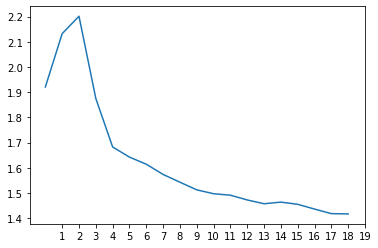

In [38]:
plt.plot(errors)
plt.xticks(range(1,20))

In [ ]:
classifier = KNeighborsClassifier(n_neighbors= 13)